# Import Packages

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon

# Import miscellaneous files and define functions

In [2]:
# Function for calculating angle between three points
def angle3pt(ax, ay, bx, by, cx, cy):
    ang = math.degrees(
        math.atan2(cy - by, cx - bx) - math.atan2(ay - by, ax - bx))
    return ang + 360 if ang < 0 else ang

# Function for calculating euclidean distance
def EuclideanDistCald(bp1xVals, bp1yVals, bp2xVals, bp2yVals, currPixPerMM):
        series = (np.sqrt((bp1xVals - bp2xVals) ** 2 + (bp1yVals - bp2yVals) ** 2)) / currPixPerMM
        return series

# Import video info file containing pixels/mm for each video
video_info = pd.read_csv('video_info.csv')

# Import feat_dict file containing dictionary with general categories for large feature dataset
with open('feat_dict.json') as json_file:
    data = json.load(json_file)
data

{'adult_body_points': ['nose_x',
  'nose_y',
  'head_center_x',
  'head_center_y',
  'ear_left_x',
  'ear_left_y',
  'ear_right_x',
  'ear_right_y',
  'neck_x',
  'neck_y',
  'side_left_x',
  'side_left_y',
  'side_right_x',
  'side_right_y',
  'body_center_x',
  'body_center_y',
  'hip_left_x',
  'hip_left_y',
  'hip_right_x',
  'hip_right_y',
  'tailbase_x',
  'tailbase_y',
  'tail_tip_x',
  'tail_tip_y',
  'tail_center_x',
  'tail_center_y',
  'tail_upper_x',
  'tail_upper_y',
  'tail_lower_x',
  'tail_lower_y'],
 'adult_body_prob': ['nose_p',
  'head_center_p',
  'ear_left_p',
  'ear_right_p',
  'neck_p',
  'side_left_p',
  'side_right_p',
  'body_center_p',
  'hip_left_p',
  'hip_right_p',
  'tailbase_p',
  'tail_tip_p',
  'tail_center_p',
  'tail_upper_p',
  'tail_lower_p'],
 'infant_and_nest_points': ['Infant1_head_x',
  'Infant1_head_y',
  'Infant1_middle_head_x',
  'Infant1_middle_head_y',
  'Infant1_middle_tail_x',
  'Infant1_middle_tail_y',
  'Infant1_tail_x',
  'Infant1_tai

# Import feature dataframes

In [3]:
%%time
# Define feature directory
features_directory = 'targets_inserted'
file_location = os.path.join(features_directory, '*.csv')

# create list of filenames for every video to be processed
# this list is the input for the video processing function
filenames = glob.glob(file_location)
videoname = []
for f in filenames:
    # establish name for output file from the input filename
    x = os.path.split(f)
    x = f
    videoname.append(x)
videoname

Wall time: 1 ms


['targets_inserted\\Gal_35_father_retreive_trial_1.csv']

In [4]:
%%time
# Read in the csv file for each feature dataframe
dfs = []
for x in videoname:
    filepath = x
    features = pd.read_csv(filepath)
    features['videoname'] = pd.Series([x] * (len(features)))
    dfs.append(features)
    print(len(dfs))

1
Wall time: 4.79 s


# Pull out start and end of investigation annotations

In [5]:
investigation_starts = {}
investigation_ends = {}
for i in range(len(dfs)):
    investigation_start = []
    investigation_end = []
    df = dfs[i]
    # Find the frame numbers in which annotation of investigation begins and the frame numbers in whic the
    # annotation of investigation ends
    for j in range(len(df)):
        if j == 0:
            if df['pup_investigation'][j] == 1:
                investigation_start.append(j)
            else:
                continue
        elif j == len(df) - 1:
            if df['pup_investigation'][j] == 1:
                investigation_end.append(j)
            else:
                continue
        else:
            if df['pup_investigation'][j] == 1 and df['pup_investigation'][j - 1] == 0:
                investigation_start.append(j)
            if df['pup_investigation'][j] == 1 and df['pup_investigation'][j + 1] == 0:
                investigation_end.append(j)
    investigation_starts[videoname[i]] = investigation_start
    investigation_ends[videoname[i]] = investigation_end

# Adult specific features

In [26]:
# adult body angle
adult_angles = {}
for i in range(len(dfs)):
    
    # Use the angle function above and the head_center, neck and body_center points to calculate the angle made by
    # these body parts
    adult_angle = dfs[i].apply(
                lambda x: angle3pt(x['head_center_x'], x['head_center_y'], x['neck_x'], x['neck_y'], 
                                   x['body_center_x'], x['body_center_y']), axis=1)
    adult_angle = adult_angle.rolling(90, min_periods=1, center=True).mean()
    adult_angles[videoname[i]] = adult_angle

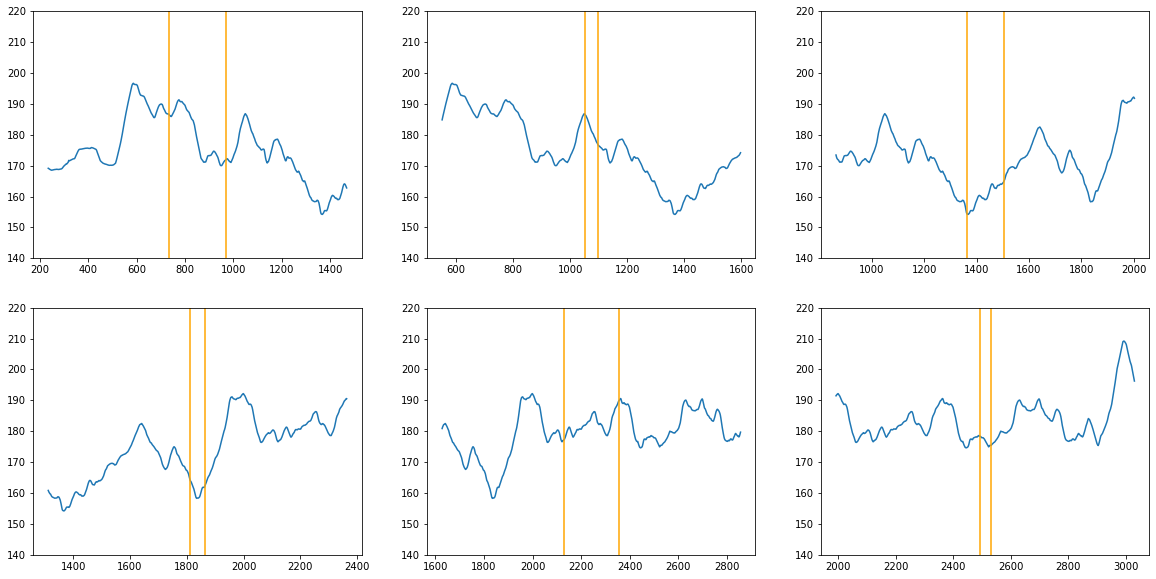

In [27]:
# Plot the curve of the calculated adult body angle against the labeled investigation behaviors
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(investigation_starts[videoname[0]])):
    angles = adult_angles[videoname[0]]
    starts = investigation_starts[videoname[0]]
    ends = investigation_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 500, ends[i] + 500)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, angles[starts[i] - 500:ends[i] + 500])
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')
    plt.ylim([140, 220])

In [59]:
# Make empty dictionaries to put features for each video into
video_adult_nest = {}
adult_nest_dist = {}
video_adult_movement = {}
adult_movement_shifted = {}
video_areas = {}
video_circularities = {}
ppm = video_info['pixels/mm'][0]
for i in range(len(dfs)):
    
    # Make empty lists for the per-frame feature calculations for each feature
    areas = []
    circularities = []
    center_xs = []
    center_ys = []
    df = dfs[i][data['adult_body_points']]
    nest_info = dfs[i][data['infant_and_nest_points']]
    
    # Make a hull for the adult body and calculate the area and circularity of the adult polygon in each
    # frame
    for j in range(len(df)):
        
        p1 = Point(df['head_center_x'][j], df['head_center_y'][j])
        p2 = Point(df['ear_right_x'][j], df['ear_right_y'][j])
        p3 = Point(df['side_right_x'][j], df['side_right_y'][j])
        p4 = Point(df['hip_right_x'][j], df['hip_right_y'][j])
        p5 = Point(df['hip_left_x'][j], df['hip_left_y'][j])
        p6 = Point(df['side_left_x'][j], df['side_left_y'][j])
        p7 = Point(df['ear_left_x'][j], df['ear_left_y'][j])
        
        polygon = Polygon([p1, p2, p3, p4, p5, p6, p7])
        
        area = polygon.area
        areas.append(area)
        
        circularity = (4 * np.pi) * area / (polygon.length) ** 2
        circularities.append(circularity)
        
        center_x = polygon.centroid.x
        center_xs.append(center_x)
        center_y = polygon.centroid.y
        center_ys.append(center_y)
    
    areas = areas / (ppm ** 2)
    
    video_areas[videoname[i]] = pd.Series(areas)
    video_circularities[videoname[i]] = pd.Series(circularities)
    
    center_xs = np.array(center_xs)
    center_ys = np.array(center_ys)
    nest_xs = nest_info['nest_centroid_home_x'].values
    nest_ys = nest_info['nest_centroid_home_y'].values
    
    # Calculate the per-frame change in the distance between the adult and the nest, summed over 90 frames, with
    # the present frame in the middle of the 90 frame window
    adult_nest_dist = EuclideanDistCald(center_xs, center_ys, nest_xs, nest_ys, ppm)
    adult_nest_dist = pd.Series(adult_nest_dist)
    adult_nest_shifted = adult_nest_dist.shift(periods=1)
    adult_nest_shifted = adult_nest_shifted.fillna(0)
    adult_nest_rate = pd.Series(adult_nest_dist.values - adult_nest_shifted.values)
    adult_nest_rate_summed = pd.Series(adult_nest_rate.rolling(90, min_periods=1, center=True).sum())
    adult_nest_dist_summed = pd.Series(adult_nest_dist.rolling(90, min_periods=1, center=True).sum())
    video_adult_nest[videoname[i]] = adult_nest_rate_summed
    adult_nest_dist[videoname[i]] = adult_nest_dist_summed
    
    # Find the movement of the adult by adding all the adult movement columns (except for any column involving the
    # nose or tail), summed over 90 frames, with the present frame in the middle of the 90 frame window
    adult_movement = dfs[i][data['movement_adult']]
    adult_movement_summed = pd.Series(np.zeros(len(adult_movement)))
    for column in adult_movement.columns:
        if 'head' in column or 'ear' in column or 'neck' in column:
            print(column)
            adult_movement_summed = adult_movement_summed + adult_movement[column]
    adult_movement_summed_shifted = adult_movement_summed.shift(periods=1)
    adult_movement_summed_shifted = adult_movement_summed_shifted.fillna(0)
    adult_movement_rate = pd.Series(adult_movement_summed.values - adult_movement_summed_shifted.values)
    adult_movement_summed = pd.Series(adult_movement_summed.rolling(90, min_periods=1, center=True).sum()) 
    adult_movement_rate = pd.Series(adult_movement_rate.rolling(90, min_periods=1, center=True).sum())
    video_adult_movement[videoname[i]] = adult_movement_summed
    adult_movement_shifted[videoname[i]] = adult_movement_rate

movement_head_center
movement_ear_left
movement_ear_right
movement_neck


In [6]:
# Find the changes in all euclidean distances between adult points (except for any distances involving nose or tail
# points), summed over 30 frames, with the present frame in the middle of the 30 frame window
euclid_rates = {}
for i in range(len(dfs)):
    adult_euclid = dfs[i][data['adult_distances']]
    summed_euclid = pd.Series(np.zeros(len(adult_euclid)))
    count = 0
    for column in adult_euclid.columns:
        if 'nose' in column or 'tail' in column:
            continue
        else:
            summed_euclid += adult_euclid[column]
            count += 1
    summed_euclid = summed_euclid / count
    summed_euclid_shifted = summed_euclid.shift(periods=1)
    summed_euclid_shifted = summed_euclid_shifted.fillna(0)
    summed_euclid_rate = summed_euclid_shifted - summed_euclid
    summed_euclid_rate90 = pd.Series(summed_euclid_rate.rolling(30, min_periods=1, center=True).sum())
    euclid_rates[videoname[i]] = summed_euclid_rate90

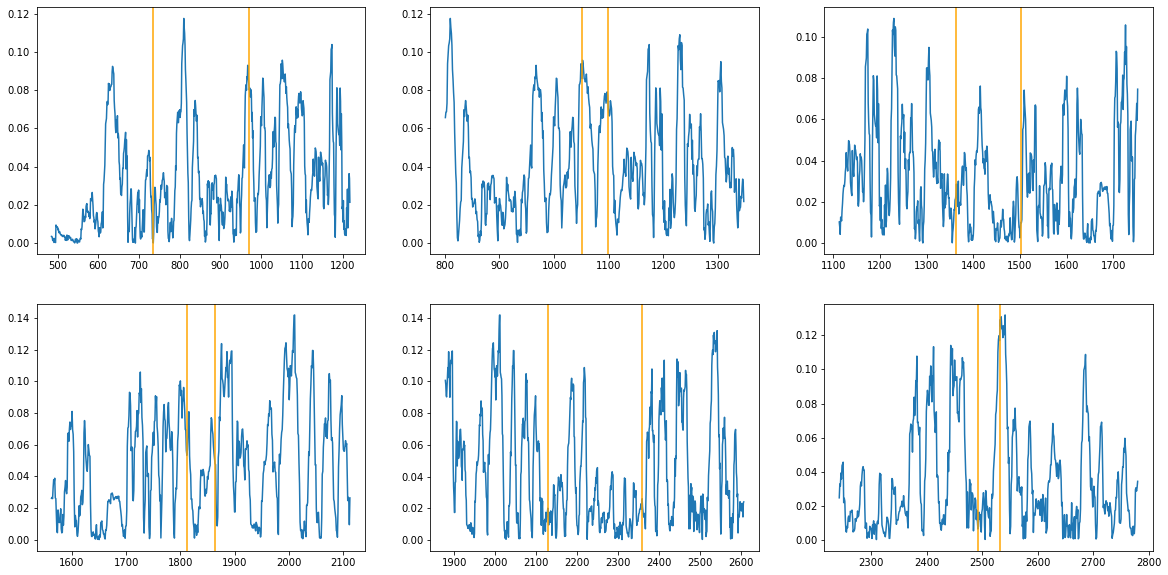

In [51]:
# Plot the curve of the adult euclidean distance rates against the labeled starts and ends of investigation behaviors
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(investigation_starts[videoname[0]])):
    euclid = euclid_rates[videoname[0]] / 8
    starts = investigation_starts[videoname[0]]
    ends = investigation_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 250, ends[i] + 250)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, abs(euclid[starts[i] - 250:ends[i] + 250]))
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')

# Adult-infant features

In [69]:
# Make empty dictionaries to put features for each video into
adult_infant = {}
adult_inf_rates = {}
ppm = video_info['pixels/mm'][0]
for i in range(len(dfs)):
    df = dfs[i]
    
    # Code for calculating adult infant distance when using the adult hull as the point of reference
    #center_xs = []
    #center_ys = []
    #for j in range(len(df)):
    #    p1 = Point(df['head_center_x'][j], df['head_center_y'][j])
    #    p2 = Point(df['ear_right_x'][j], df['ear_right_y'][j])
    #    p3 = Point(df['side_right_x'][j], df['side_right_y'][j])
    #    p4 = Point(df['hip_right_x'][j], df['hip_right_y'][j])
    #    p5 = Point(df['hip_left_x'][j], df['hip_left_y'][j])
    #    p6 = Point(df['side_left_x'][j], df['side_left_y'][j])
    #    p7 = Point(df['ear_left_x'][j], df['ear_left_y'][j])
        
    #    polygon = Polygon([p1, p2, p3, p4, p5, p6, p7])
        
    #    center_x = polygon.centroid.x
    #    center_xs.append(center_x)
    #    center_y = polygon.centroid.y
    #    center_ys.append(center_y)
    
    #center_xs = dfs[i]['neck_x']
    # np.array(center_xs)
    #center_ys = dfs[i]['neck_y']
    # np.array(center_ys)
    #infant1_center_xs = dfs[i]['Inf1_points_avg_x']
    #infant1_center_ys = dfs[i]['Inf1_points_avg_y']
    #infant2_center_xs = dfs[i]['Inf2_points_avg_x']
    #infant2_center_ys = dfs[i]['Inf2_points_avg_y']
    
    # Make an empty list for the values of adult infant distance for each frame
    adult_infants_dist = []
    for j in range(len(df)):
        #adult_infant1_dist = ((np.sqrt((center_xs[j] - infant1_center_xs[j]) ** 2 + 
        #                               (center_ys[j] - infant1_center_ys[j]) ** 2)) / ppm)
        #adult_infant2_dist = ((np.sqrt((center_xs[j] - infant2_center_xs[j]) ** 2 + 
        #                               (center_ys[j] - infant2_center_ys[j]) ** 2)) / ppm)
        
        #print(j, center_xs[j], center_ys[j], infant2_center_xs[j], infant2_center_ys[j])
        #print(j, adult_infant1_dist, adult_infant2_dist)
        
        # Find the minimum of the distance between adult and infant1 and the adult and infant2
        adult_infant1_dist = dfs[i]['head_center_to_Inf1_points_avg'][j]
        adult_infant2_dist = dfs[i]['head_center_to_Inf2_points_avg'][j]
        adult_infants_dist.append(min(adult_infant1_dist, adult_infant2_dist))
    # Sum the values of the adult infant distance over 90 frames, with the present frame in the middle of the 90
    # frame window
    adult_infants_dist = pd.Series(adult_infants_dist)
    adult_inf_dist_shifted = adult_infants_dist.shift(periods=1)
    adult_inf_dist_shifted = adult_inf_dist_shifted.fillna(0)
    adult_inf_rate = pd.Series(adult_infants_dist.values - adult_inf_dist_shifted.values)
    adult_infants_dist = adult_infants_dist.rolling(150, min_periods=1, center=True).sum()
    adult_inf_rate = adult_inf_rate.rolling(90, min_periods=1, center=True).mean()
    adult_infant[videoname[i]] = adult_infants_dist
    adult_inf_rates[videoname[i]] = adult_inf_rate

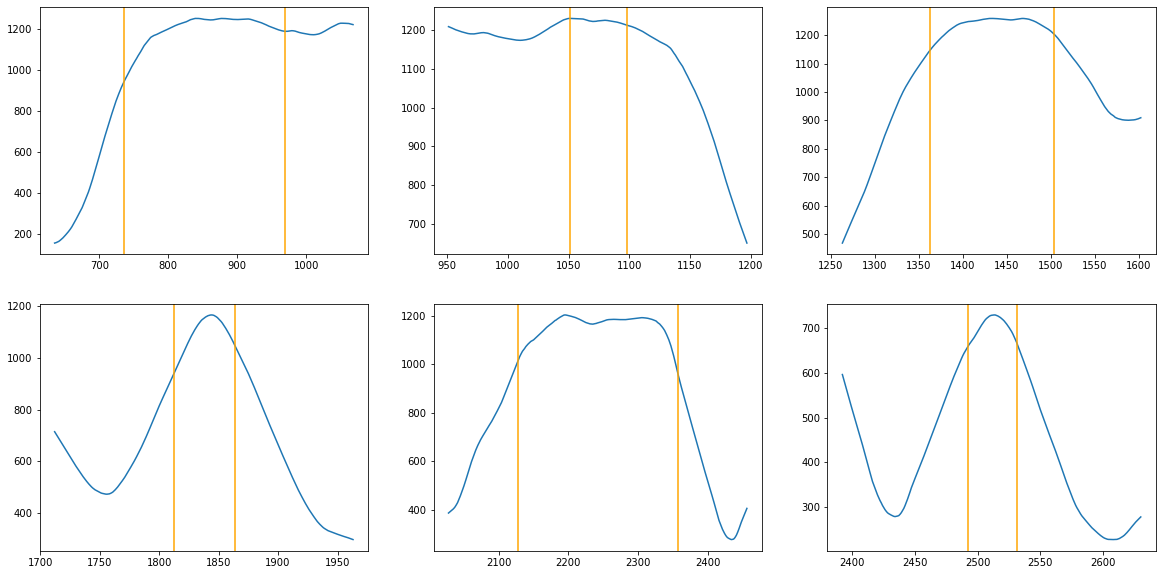

In [73]:
# Plot the adult-infant distance feature against the labeled investigation behavior
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(investigation_starts[videoname[0]])):
    ad_mov = adult_nest_dist[videoname[0]]
    starts = investigation_starts[videoname[0]]
    ends = investigation_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 100, ends[i] + 100)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, abs(ad_mov[starts[i] - 100:ends[i] + 100]))
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')

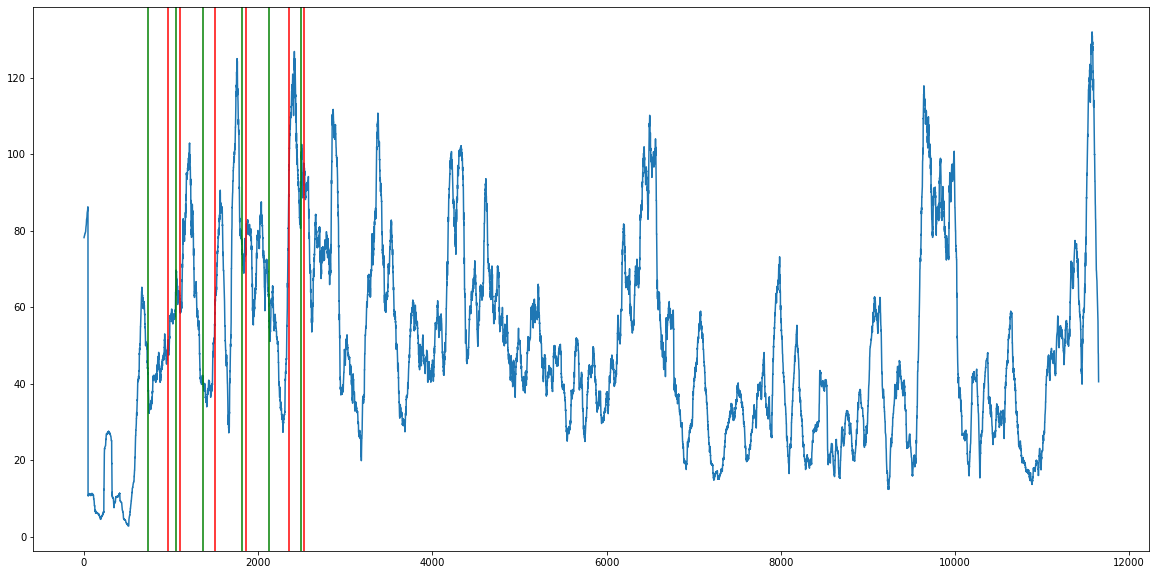

In [67]:
# Plot the curve of adult infant distance over the entire video, with the starts of investigation as green lines and 
# the ends of investigation as red lines
plt.figure(figsize=(20, 10))
ad_mov = video_adult_movement[videoname[0]]
plt.plot(ad_mov.index, ad_mov)
for i in range(len(investigation_starts[videoname[0]])):
    starts = investigation_starts[videoname[0]]
    ends = investigation_ends[videoname[0]]
    plt.axvline(starts[i], color='green')
    plt.axvline(ends[i], color='red')

# Infant specific features

In [73]:
# Sum the probabilities of all the infant points
sum_infant_probs = {}
for i in range(len(dfs)):
    infant_probs = dfs[i][data['infant_prob']]
    avgd_probs = pd.Series(np.zeros(len(infant_probs)))
    for column in infant_probs.columns:
        sum_probs = avgd_probs + infant_probs[column]
    sum_infant_probs[videoname[i]] = sum_probs

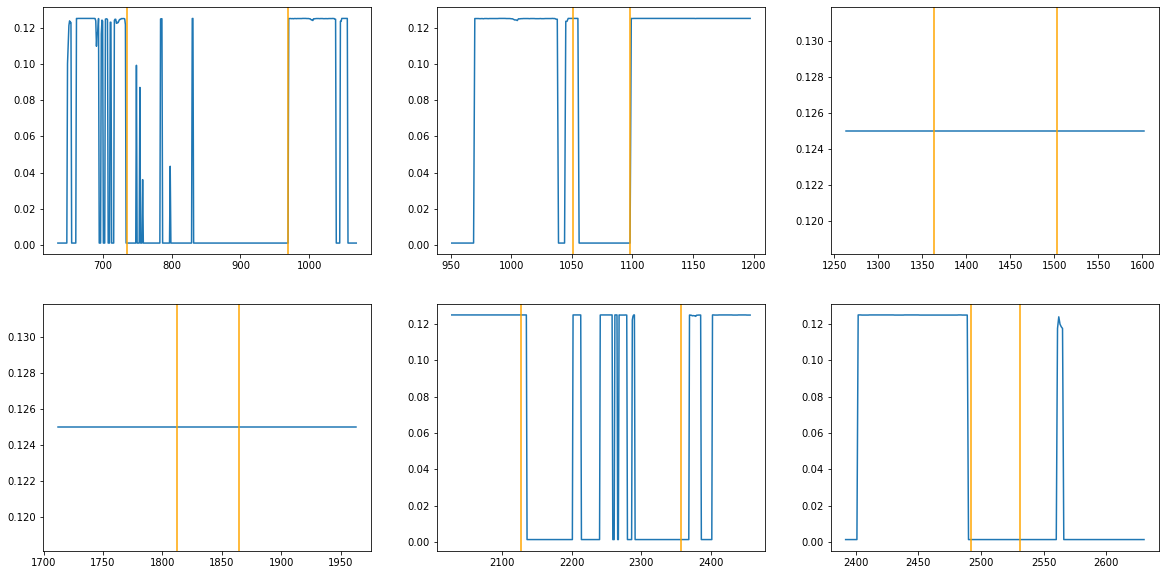

In [75]:
# Plot the curve of the summed infant probabilities against the labeled starts and ends of investigation
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(investigation_starts[videoname[0]])):
    sum_probs = sum_infant_probs[videoname[0]] / 8
    starts = investigation_starts[videoname[0]]
    ends = investigation_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 100, ends[i] + 100)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, abs(sum_probs[starts[i] - 100:ends[i] + 100]))
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')

In [150]:
# Get the summed movement of all points of both infants
infants_mov = {}
for i in range(len(dfs)):
    inf_mov = dfs[i]['Total_movement_infants']
    inf_mov = pd.Series(inf_mov)
    inf_mov = pd.Series(inf_mov.rolling(150, min_periods=1, center=True).mean())
    infants_mov[videoname[i]] = inf_mov

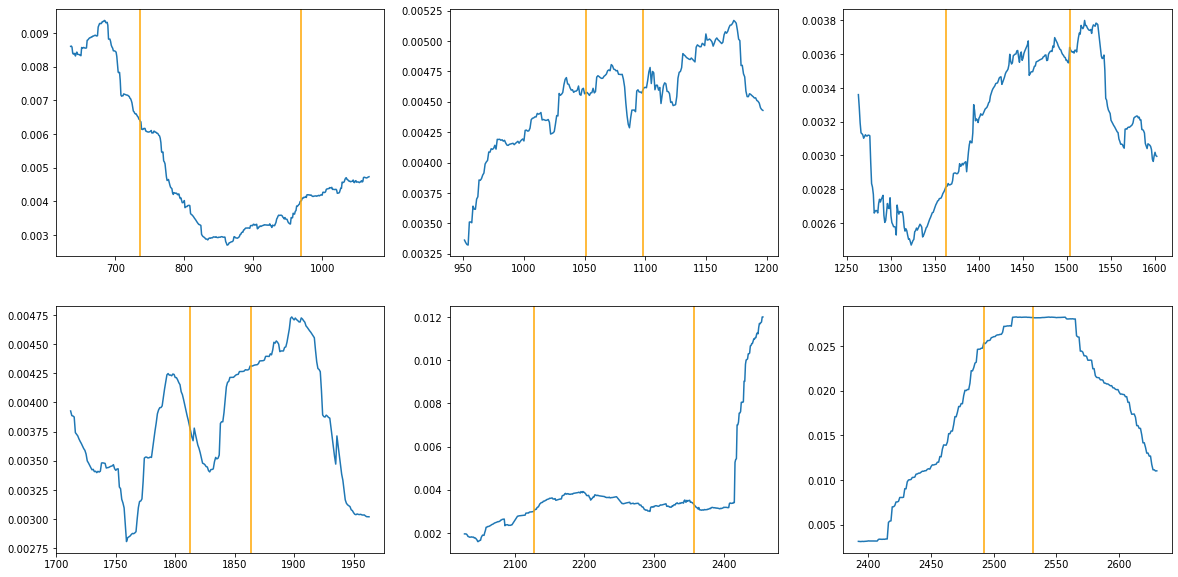

In [151]:
# Plot the curve for summed infant movements against the labeled starts and ends of investigation behaviors
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(investigation_starts[videoname[0]])):
    inf_mov = infants_mov[videoname[0]] / 8
    starts = investigation_starts[videoname[0]]
    ends = investigation_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 100, ends[i] + 100)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, abs(inf_mov[starts[i] - 100:ends[i] + 100]))
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')